# Latency Arbitrage
## Central CDA Model

continuous double auction

In [1]:
import numpy as np
import bisect
import matplotlib.pyplot as plt
from collections import deque

In [2]:
class KeyWrapper:
    def __init__(self, iterable, key):
        self.it = iterable
        self.key = key

    def __getitem__(self, i):
        return self.key(self.it[i])

    def __len__(self):
        return len(self.it)

In [3]:
def surplus(ask,bid,t):
    # ask/bid order: [price,valuation,time placed]
    p = ask[0] # assmue ask is the incumbent order
    if t is ask[2]: # unless bid is...
        p = bid[0]
    return  np.exp(-rho*(t-bid[2]))*(bid[1]-p) + \
            np.exp(-rho*(t-ask[2]))*(p-ask[1])

In [4]:
nt = 15000 #15000
nbt = 250
a = 0.001
r_bar = 100000
k = 0.05
s2pv = 100000000
s2s = 150000000
R = 2000
rho = 0.0006
l = 0.075 # an ZI agent arrives per 13 to 14 time steps
delta = 100 # variable, ranging from 0 10 1000 

In [5]:
spv = 10000
ss = s2s**0.5 #12247.4

In [6]:
np.random.seed(12345)
ZI_agent_arrival = np.random.exponential(1/l,nt)
u = np.random.normal(0,ss,nt)

In [7]:
NBBO_ask = [float('inf'),float('inf'),0]
NBBO_bid = [-float('inf'),-float('inf'),0]
SIP_q = deque([])
M1_ask_q = deque([[float('inf'),float('inf'),0]])
M1_bid_q = deque([[-float('inf'),-float('inf'),0]])
r = [r_bar]
t_prev_arrival = 0
n_arrival = 0
n_orders = 0
total_surplus = 0

for t in range(1,nt):
    # update price
    r.append(max(0,k*r_bar+(1-k)*r[t-1]+u[t]))
    
    # see if agent arrives
    if (n_orders < nbt and t_prev_arrival+ZI_agent_arrival[n_arrival]<t):
        # update arrival event scheduling
        t_prev_arrival += ZI_agent_arrival[n_arrival]
        n_arrival += 1
        # generate evaluation and place order
        d = np.random.normal(r[t],spv)
        PV = max(0,d)
        if (np.random.normal() > 0.5): # buy
            P = np.random.uniform(PV-R,PV)
            if (P >= 0):
                # Route to the right market
                # TODO
                order = [P,PV,t]
                idx = bisect.bisect(KeyWrapper(M1_bid_q, key=lambda c: c[0]), order[0])
                M1_bid_q.insert(idx, order)
                n_orders += 1
        else: # sell
            P = np.random.uniform(PV,PV+R)
            if (P >= 0):
                # Route to the right market
                # TODO
                order = [P,PV,t]
                idx = bisect.bisect(KeyWrapper(M1_ask_q, key=lambda c: c[0]), order[0])
                M1_ask_q.insert(idx, order)
                n_orders += 1
    
    # clear market bid-ask price
        # Clear if ask < bid
        #TODO
        if (M1_ask_q[0][0] <= M1_bid_q[-1][0]):
            ask = M1_ask_q.popleft()
            bid = M1_bid_q.pop()
            total_surplus += surplus(ask,bid,t)
            
        # This entry needs order status from all markets
        # TODO 
        sip_entry = [t+delta,M1_ask_q[0],M1_bid_q[-1]]
        idx = bisect.bisect(KeyWrapper(SIP_q, key=lambda c: c[0]), sip_entry[0])
        SIP_q.insert(idx, sip_entry)

    # update NBBO (if previously scheduled)
    if (SIP_q and SIP_q[0][0]<t):
        NBBO_ask = min(NBBO_ask,SIP_q[0][1], key=lambda c: c[0])
        NBBO_bid = max(NBBO_bid,SIP_q[0][2], key=lambda c: c[0])
        SIP_q.popleft()
    
    # calculate surplus
        # TODO
        

In [8]:
SIP_q

deque([])

In [9]:
NBBO_ask,NBBO_bid

([22948.577946232126, 21706.72431177901, 2980],
 [89060.0378317397, 90045.38542818885, 229])

In [10]:
len(M1_ask_q)+len(M1_bid_q)

128

In [11]:
M1_ask_q

deque([[66945.23003918238, 65690.84985841862, 3263],
       [67353.65146637813, 66313.19850493164, 2913],
       [67880.97495042998, 67820.10654721103, 3163],
       [68935.74980354664, 67350.63072888817, 3266],
       [69469.41813195958, 67841.82499950894, 3215],
       [70583.9736327646, 68985.16055597285, 3336],
       [71790.82246416358, 70965.04017715633, 3166],
       [73362.20329915846, 72551.0783693597, 3159],
       [74459.96422340351, 73770.27102030553, 3165],
       [84125.37284154567, 82432.66541769757, 2249],
       [85524.68151434106, 85188.01637226922, 2625],
       [86031.18081704271, 84079.07897096242, 3137],
       [86839.83309645913, 86582.88072782525, 2025],
       [86981.74808459854, 85406.82213957283, 2624],
       [90165.19109883493, 88596.4260084682, 2949],
       [90327.22611732018, 90262.38570703758, 2413],
       [91517.01384559867, 91360.58231194121, 3164],
       [93210.72237517401, 93154.93294323448, 2555],
       [93426.50589369338, 93110.47851600335, 128

In [12]:
M1_bid_q

deque([[-inf, -inf, 0], [20108.73285600028, 21129.929629892336, 1161]])

In [13]:
total_surplus

2681658.2937285868

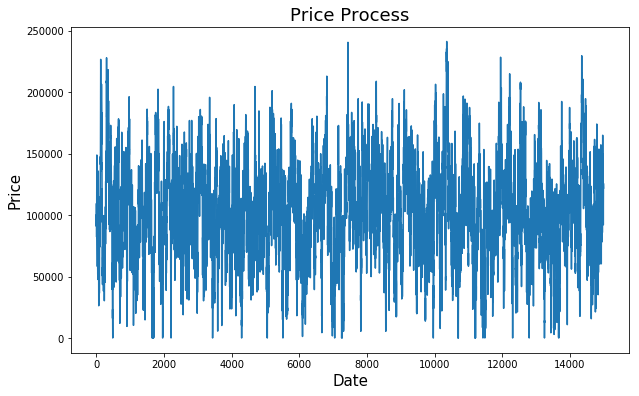

In [14]:
plt.figure(figsize=(10,6))
plt.plot(r)
plt.title("Price Process", fontsize=18)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Price", fontsize=15)
plt.show()